- **Module:** read_and_map_aeronet.ipynb
- **Authors:** Petar Grigorov, Alqamah Sayeed, and Pawan Gupta
- **Organization:**NASA AERONET (https://aeronet.gsfc.nasa.gov/)
- **Date:**06/18/2023
- **Purpose:** to access and map the AERONET data
- **Disclaimer:** The code is for demonstration purposes only. Users are responsible to check for accuracy and revise to fit their objective.
- **Contact:** report any concern or question related to the code to pawan.gupta@nasa.gov

**Required packages installation and importing**

In [ ]:
!pip install cartopy
!pip install --no-binary shapely shapely --force
!pip install beautifulsoup4
!pip install requests
!pip install geopandas

from bs4 import BeautifulSoup      #reads data from website (web scraping)
import requests                    #useful for sending HTTP requests using python
import shutil                      #useful for creating zip files
import numpy as np                 #for array manipulation
import datetime                    #for time data manipulation
import pandas as pd                #for data querying and processing
import geopandas as gpd            #same as pandas, but for geospatial data
import matplotlib.pyplot as plt    #for creating plots

import cartopy.crs as ccrs         #for creating geographical maps
import cartopy.feature as cfeature
from copy import deepcopy as dc

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 36.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.9 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11080589 sha256=5786468cc4754de5b8712fead634d32fd4ee8fbd3e2fcbab65e99cbc18f728ec
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 34.1 MB/s eta 0:00:00
  Created wheel for shapely: filename=shapely-2.0.1-cp310-cp31

**Connecting and mounting local drive onto colab notebook**

In [ ]:
from google.colab import files      #ensures output zip file can be downloaded
from google.colab import drive      #imports local google drive
drive.mount('/drive')               #mounts local google drive onto colab
!mkdir Output                       #makes directory where output files will be stored

Mounted at /drive


**Setup input parameters such as date, data level, averaging type, AOD range for mapping, AOD/Angstrom exponent, and geographical limits**

In [ ]:
dt_initial = '20230626'                 #starting date YYYYMMDD format
dt_final = '20230702'                   #final date YYYYMMDD format
level = 1.5                             #AERONET data level
average_type = 1                        #daily (1), hourly (2), timeavg (3)
vis_min = 0.0                           #any AOD/AE with smaller value will show as green on the color map, adjust as necessary
vis_max = 1.0                           #any AOD/AE with larger value will show as red on the color map, adjust as necessary
feature_choice = 1                      #Enter '1' if you are specifying an AOD wavelength or '2' if you are specifying an Angstrom exponent
wavelength = 500                        #Available choices: 1640, 1020, 870, 865, 779, 675, 667, 620, 560, 555, 551, 532, 531, 510, 500, 490, 443, 440, 412, 400, 380, 340
Angstrom_exp = '440-675'                #Available choices: '440-870','380-500','440-675','500-870','340-440','440-675'
long_west,long_east = -135,-65          #Enter longitude bounds
lat_south,lat_north = 23,53             #Enter latitude bounds

**Get desired AERONET data using web services, then scraping data from website**

In [ ]:
yr_initial = dt_initial[:4]               #initial year
mon_initial = dt_initial[4:6]             #initial month
day_initial = dt_initial[6:]              #initial day

yr_final = dt_final[:4]                   #final year
mon_final = dt_final[4:6]                 #final month
day_final = dt_final[6:]                  #final day

if level == 1 or level == 1.0:
  level = 10
elif level == 1.5:
  level = 15
elif level == 2 or level == 2.0:
  level = 20
else:
  print("\nIncorrect input for data level type. Defaulting to level 1.5...")
  level = 15

if average_type == 1:           #sets up time range bounds based on average type
  max_days = 30                 #for daily averages, data cannot exceed a month
elif average_type == 2:         #for hourly averages, data cannot exceed a week
  max_days = 7                  #for site averages, time range is unlimited
elif average_type == 3:         #If the input is wrong, program defaults to daily averages
  max_days = 9999999999999
else:
  average_type = 1
  max_days = 30
  print("\nIncorrect input for average type. Defaulting to daily averages (1)...")

if vis_min < 0 or vis_max <= 0:
  vis_min = 0
  vis_max = 1
  print("\nIncorrect entry. Numbers cannot be negative. Defaulting to [0,1] range...")
elif vis_min >= vis_max:         #if someone accidentally switches the colorbar limits, where the max is he smaller number, the values are swapped.
  vis_min = 0
  vis_max = 1
  print("\nColorbar limit input does not match format. Lower bound cannot be greater than the upper. Defaulting to [0,1] range..")
if level == 20 and int(yr_initial) == datetime.date.today().year:                 #if user wants level 2 data for the current year, program alerts that data may not be available
  level = 15                                                                      #defaults to level 1.5 data
  print("\nThere is no level 2 data available for the current year. Defaulting to level 1.5 data...")

date_initial = pd.to_datetime(dt_initial)
date_final = pd.to_datetime(dt_final)
delta = date_final - date_initial

if delta.days > max_days:
  print("\nNote that the selected time frame is too large, which may cause the program to crash.")

base_web = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?year=',yr_initial,'&month=',mon_initial,'&day=',day_initial,'&year2=',yr_final,'&month2=',mon_final,'&day2=',day_final,'&AOD',level,'=1&AVG=10'

def convertTuple(tup):              #this function converts the url above from tuple to a string. It basically removes the commas.
    st = ''.join(map(str, tup))
    return st

url = convertTuple(base_web)        #URL tuple is passed, and converted to string

soup = BeautifulSoup(requests.get(url).text) #web services contents are read here from URL

if len(soup) <= 1:                    #alerts the user if the data cannot be read due to improper parameter inputs
  print("\nThe link could not be generated due to issues with the input. Please try again.")

**Read and filter downloaded data as per user average type specification**

In [ ]:
with open(r'/content/sample_data/Test.txt' ,"w") as oFile:          #writes the data scraped from "beautiful soup" to a text file on your local Google drive
    oFile.write(str(soup.text))
    oFile.close()

df = pd.read_csv(r'/content/sample_data/Test.txt',skiprows = 5)     #loads the csv data into a Pandas dataframe
df = df.replace(-999.0, np.nan)                                     #replaces all -999.0 vakyes with NaN; helps with accurate data aggregation
df.rename(columns={'Site_Latitude(Degrees)': 'Site_Latitude', 'Site_Longitude(Degrees)': 'Site_Longitude'}, inplace = True)
df[['Day','Month','Year']] = df['Date(dd:mm:yyyy)'].str.split(':',expand=True)                                #splits the date column and then joins it back together using "-" instead of ":"
df['Date'] = df[['Year','Month','Day']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")       #because datetime format in python does not recognize colons
df = df.drop(columns=['Year','Month','Day','Date(dd:mm:yyyy)'])                     #drops the old date columns, only keeps the new one
df.insert(1, 'Date', df.pop('Date'))                                                #moves the new Date column to the front of the data frame
df['Date']= pd.to_datetime(df['Date'])                                              #converts the new date column to datetime format

if average_type == 1:
  df = df.drop(columns=['Time(hh:mm:ss)'])                              #If user wants daily averages, the "Time" column is redundant and will be dropped from the data frame
  df = df.groupby(['AERONET_Site', 'Date']).mean()                      #The "groupby" function is used to obtain average daily (or hourly) AOD wavelength for each AERONET site.                                                                 # np.mean() function is used to compute the arithmetic average of the array ignoring the NaN value
elif average_type == 2:
  df['Hour'] = np.nan                                                   #This code creates a blank column "Hour".
  for i in range(len(df['Time(hh:mm:ss)'])):                            #The following for-loop truncates the last 6 characters of the Time(hh:mm:ss) column and assigns them to the new "Hour" column.
    df['Hour'][i] = df['Time(hh:mm:ss)'][i][:-6]                        #That way that new column only has the hours, while minutes and seconds are truncated.
  df.insert(3, 'Hour', df.pop('Hour'))                                  #The original Time column is kept in the dataframe.
  df = df.groupby(['AERONET_Site', 'Date','Hour']).mean()
elif average_type == 3:
  df = df.drop(columns=['Day_of_Year', 'Day_of_Year(Fraction)'])       #if the site averages are selected, the day of year, date and hour are now redundant. Instead, the code
  df = df.groupby(['AERONET_Site']).mean()                             #groups dataset by the Aeronet site location, and takes the total time average for each location

**AOD Wavelength or Angstrom Exponent Selection**

In [ ]:
AOD_col = ['AOD_1640nm','AOD_1020nm','AOD_870nm','AOD_865nm','AOD_779nm','AOD_675nm','AOD_667nm','AOD_620nm','AOD_560nm',
       'AOD_555nm','AOD_551nm','AOD_532nm','AOD_531nm','AOD_510nm','AOD_500nm','AOD_490nm','AOD_443nm','AOD_440nm',
       'AOD_412nm','AOD_400nm','AOD_380nm','AOD_340nm']                                                   #list of AOD columns, used for mapping user input to them

Ang_exp_col = ['440-870_Angstrom_Exponent','380-500_Angstrom_Exponent','440-675_Angstrom_Exponent',
               '500-870_Angstrom_Exponent','340-440_Angstrom_Exponent','440-675_Angstrom_Exponent']       #list of Angstrom Exponent columns, used for mapping user input to them

AOD_val = [1640, 1020, 870, 865, 779, 675, 667, 620, 560, 555, 551, 532, 531, 510, 500, 490, 443, 440, 412, 400, 380, 340]   #expected user input choices for AOD
Ang_exp_val = ['440-870','380-500','440-675','500-870','340-440','440-675']                                                  #expected user input choices for AE

if feature_choice == 1:
  if wavelength in AOD_val:             #if user input for AOD wavelength matches a value in the list, code proceeds forward. Otherwise it prompts user to try again
    for i in range(len(AOD_col)):
      if wavelength == AOD_val[i]:      #code scans the list of columns and list of possible values, and matches user input to the appropriate column name
        df = df[['Site_Latitude','Site_Longitude', AOD_col[i]]]         #if a match exists, the column name is matched to the actual column and it is then appended to the dataset
  else:
    df = df[['Site_Latitude','Site_Longitude','AOD_500nm']]
    print("\nInput for AOD wavelength is not in list. Defaulting to 500nm...")
elif feature_choice == 2:
  if Angstrom_exp in Ang_exp_val:     #if user input for Angstrom Exponent matches a value in the list, code proceeds forward. Otherwise it prompts user to try again
    for i in range(len(Ang_exp_col)):
      if Angstrom_exp == Ang_exp_val[i]:  #code scans the list of columns and list of possible values, and matches user input to the appropriate column nam
        df = df[['Site_Latitude','Site_Longitude', Ang_exp_col[i]]]     #if a match exists, the column name is matched to the actual column and it is then appended to the dataset
  else:
    df = df[['Site_Latitude','Site_Longitude','440-675']]
    print("\nInput for Angstrom Exponent is not in list. Defaulting to 440-675...")
else:
  feature_choice == 1
  print("\nIncorrect input for feature choice. Defaulting to AOD wavelength (1)...")
  if wavelength in AOD_val:             #if user input for AOD wavelength matches a value in the list, code proceeds forward. Otherwise it prompts user to try again
    for i in range(len(AOD_col)):
      if wavelength == AOD_val[i]:      #code scans the list of columns and list of possible values, and matches user input to the appropriate column name
        df = df[['Site_Latitude','Site_Longitude', AOD_col[i]]]         #if a match exists, the column name is matched to the actual column and it is then appended to the dataset
  else:
    df = df[['Site_Latitude','Site_Longitude','AOD_500nm']]
    print("\nInput for AOD wavelength is not in list. Defaulting to 500nm...")

df = df.dropna() #Drops NaN or -999.0 values

**Specify geographical coordinates to zoom into area of interest.**

In [ ]:
if lat_south > lat_north:
  print("\nGeographical input does not match format. Defaulting to world map...")
  lat_south = -90
  lat_north = 90

if long_west > long_east:
  print("\nGeographical input does not match format. Defaulting to world map...")
  long_west = -180
  long_east = 180

df = df[(df['Site_Latitude'] >= lat_south) & (df['Site_Latitude'] <= lat_north)]                  #filters new dataframe to AERONET sites within the geographical bounds
df = df[(df['Site_Longitude'] >= long_west) & (df['Site_Longitude'] <= long_east)]
df = df.reset_index()

AERONET_Site       Date  Site_Latitude  Site_Longitude  AOD_500nm
0    ARM_La_Jolla 2023-06-26      32.866906     -117.256723   0.094165
1    ARM_La_Jolla 2023-06-27      32.866906     -117.256723   0.120118
2    ARM_La_Jolla 2023-06-28      32.866906     -117.256723   0.069984
3    ARM_La_Jolla 2023-06-29      32.866906     -117.256723   0.112454
4    ARM_La_Jolla 2023-06-30      32.866906     -117.256723   0.158780
..            ...        ...            ...             ...        ...
645       YUMA_SL 2023-06-28      32.644138     -114.582780   0.148150
646       YUMA_SL 2023-06-29      32.644138     -114.582780   0.180271
647       YUMA_SL 2023-06-30      32.644138     -114.582780   0.163322
648       YUMA_SL 2023-07-01      32.644138     -114.582780   0.116981
649       YUMA_SL 2023-07-02      32.644138     -114.582780   0.113946

[650 rows x 5 columns]

**Map the AODs/AE using PlateCarree projection**

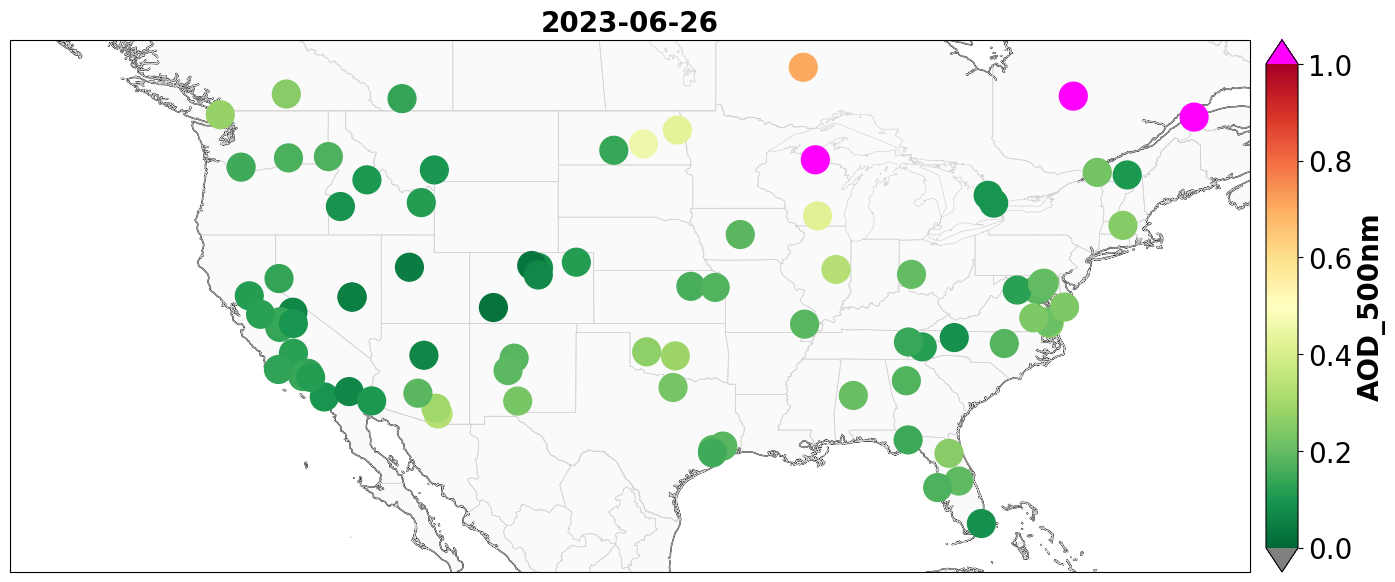

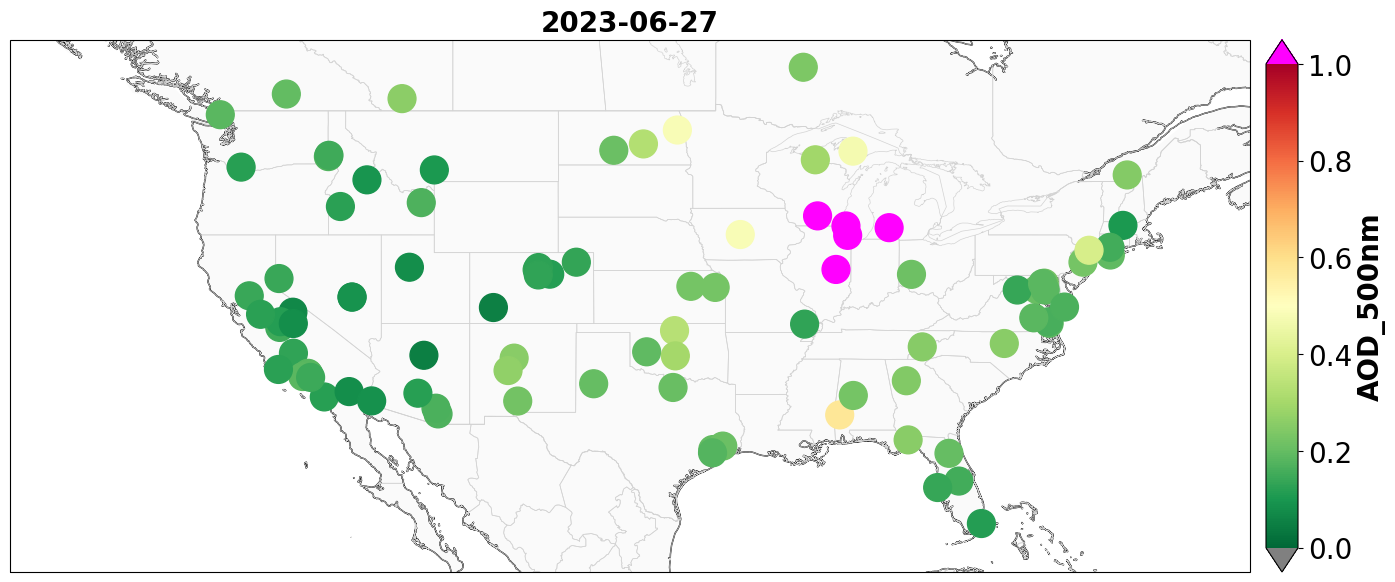

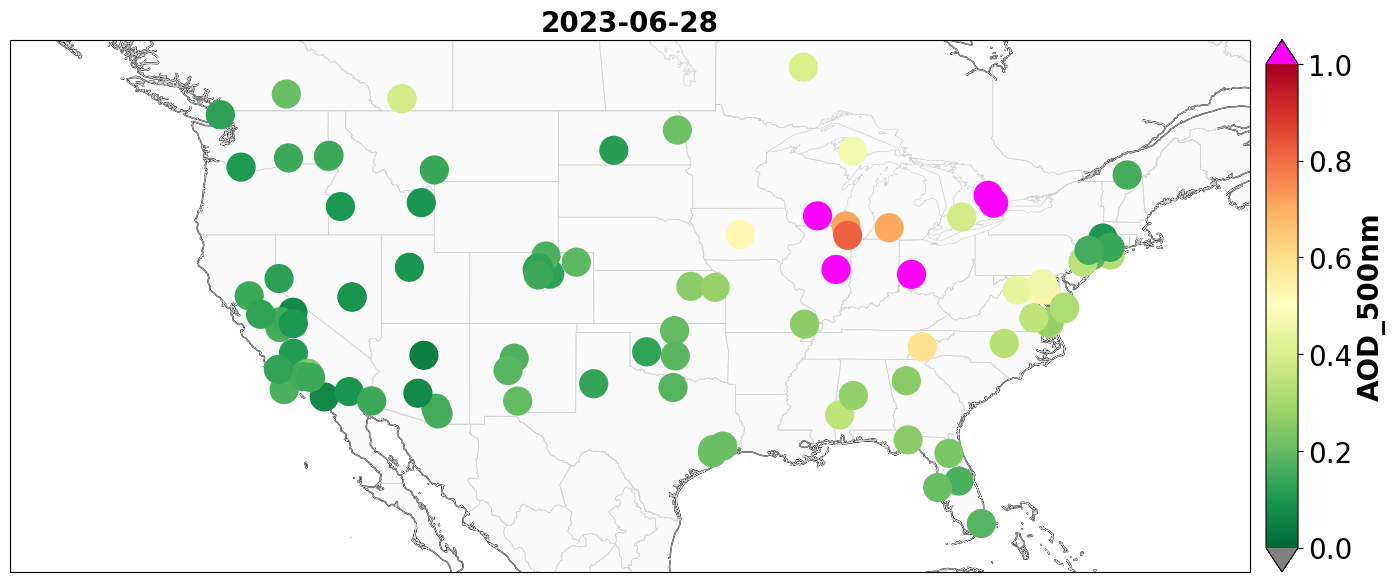

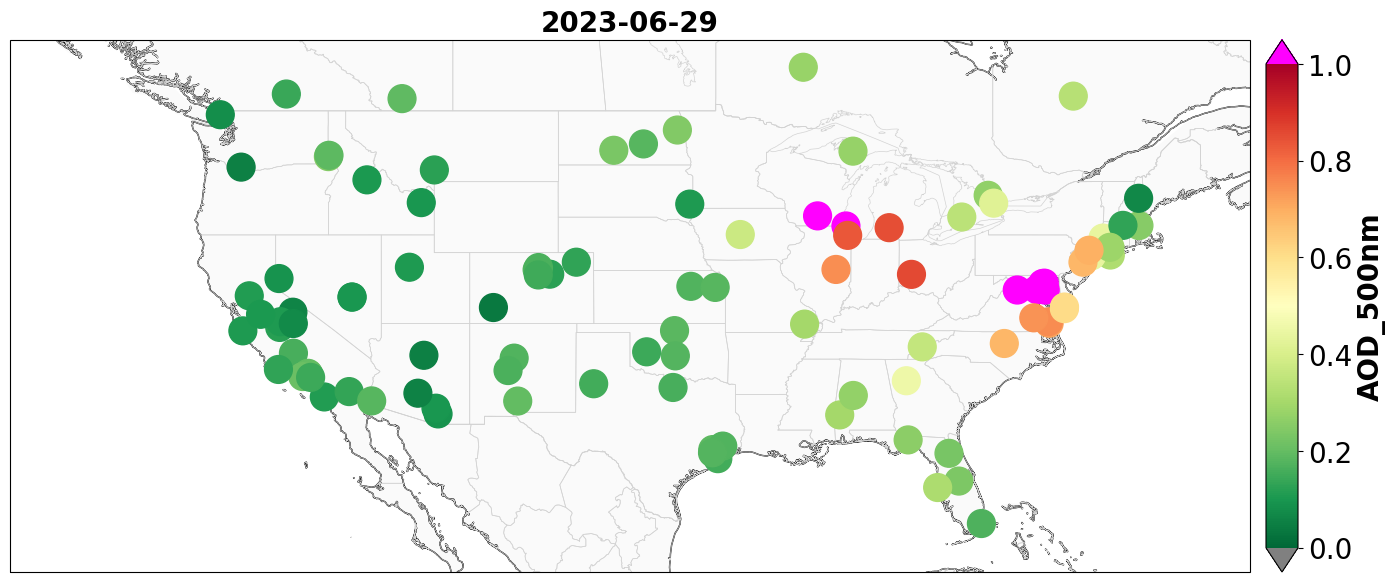

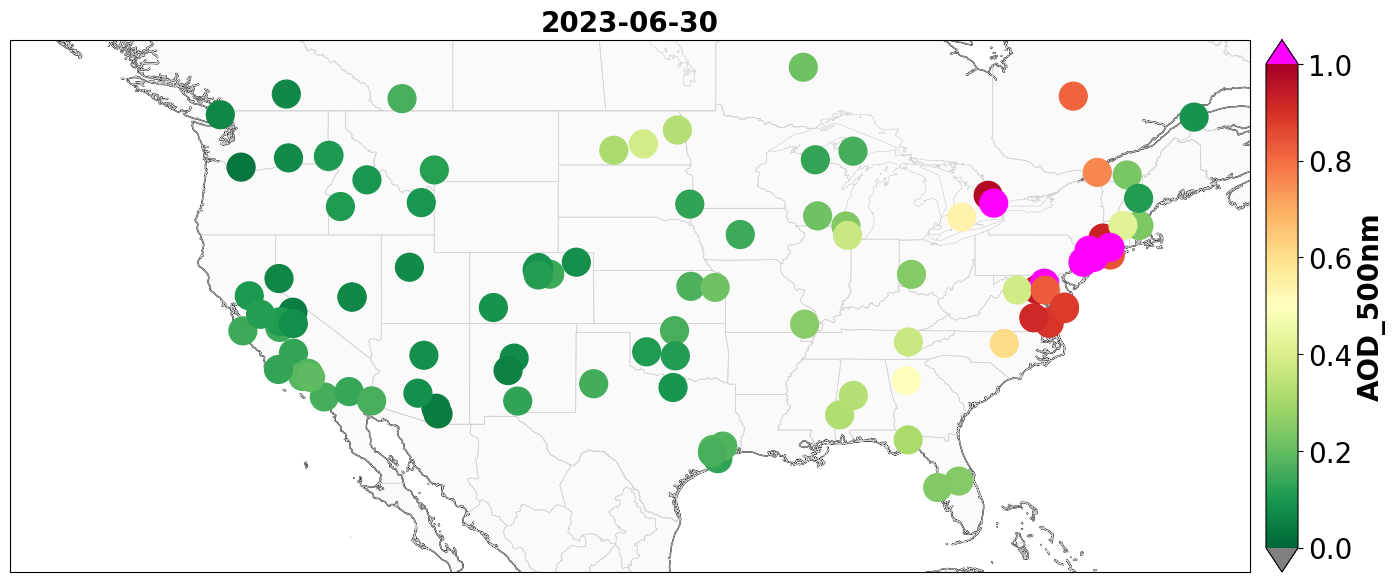

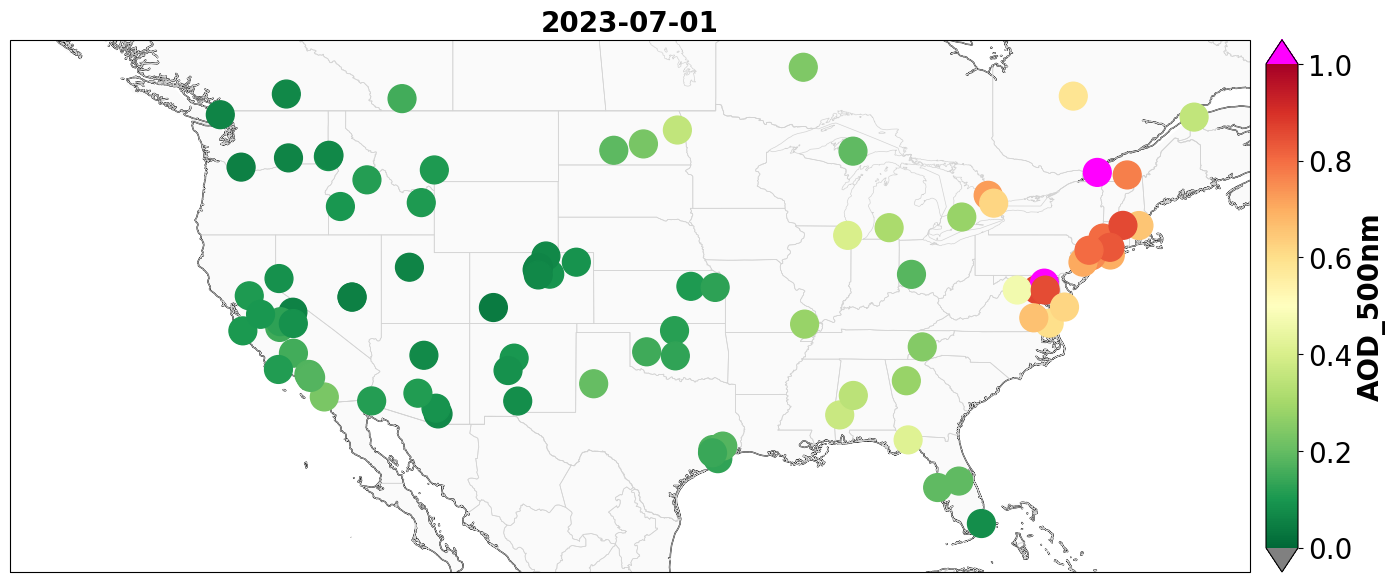

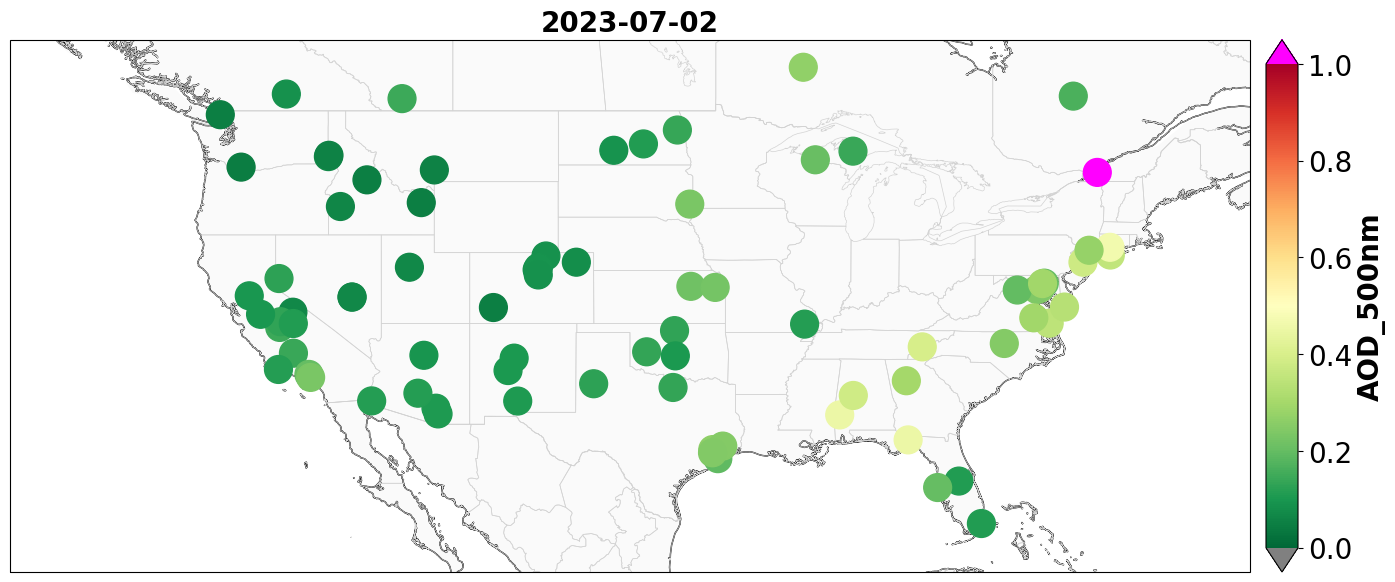

In [ ]:
from copy import deepcopy
## Always use deep copy otherwise value of main variable might change when changing the values of copied variable.
geo_df = deepcopy(df)

projection=ccrs.PlateCarree()
#projection=ccrs.Orthographic()
outdir='/content/Output/'


colbar='RdYlGn_r' #https://matplotlib.org/stable/tutorials/colors/colormaps.html
#colbar='rainbow'


if average_type == 1:
  date_list = geo_df[['Date']].astype(str)
  date_list = date_list.to_numpy()
  date_list = np.unique(date_list)

  for i in range(len(date_list)):
    geo_df = dc(df)

    fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
    #ax.set_extent([long_west,long_east,lat_south,lat_north],crs=ccrs.PlateCarree())
    plt.xlim([long_west,long_east])
    plt.ylim([lat_south,lat_north])

    # Comment next 2 lines if you don't want grey color map
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

    geo_df = geo_df.loc[geo_df['Date'] == date_list[i]].reset_index(drop=True)
    colbar = plt.cm.get_cmap('RdYlGn_r')
    colbar.set_extremes(under='gray',over='magenta')
    cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                c=geo_df[geo_df.columns[-1]],
                cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=1)
    #ax.set_title(date_list[i])
    ax.set_title(date_list[i],size=20, weight='bold')
    #ax.grid(alpha=0.1)
    # Add coastlines
    ax.coastlines(resolution='10m',zorder=0)

    # Add state and country boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

    #Add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar=plt.colorbar(cm, cax=cax, extend = 'both')
    cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
    tick_font_size = 20
    cbar.ax.tick_params(labelsize=tick_font_size)

    fig.savefig(outdir+'Output_'+str(date_list[i])+'.png',bbox_inches='tight',dpi=400)
    plt.show()


elif average_type == 2:
  geo_df = dc(df)
  geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
  geo_df['Hour'] = geo_df['Hour'].dt.time
  geo_df['Date_Time'] = geo_df.apply(lambda x : pd.datetime.combine(x['Date'],x['Hour']),1)
  geo_df.insert(3, 'Date_Time', geo_df.pop('Date_Time'))
  geo_df = geo_df.drop(columns=['Date', 'Hour'])

  date_list = geo_df[['Date_Time']].astype(str)
  date_list = date_list.to_numpy()
  date_list = np.unique(date_list)

  for i in range(len(date_list)):
    geo_df = dc(df)
    geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
    geo_df['Hour'] = geo_df['Hour'].dt.time
    geo_df['Date_Time'] = geo_df.apply(lambda x : pd.datetime.combine(x['Date'],x['Hour']),1)
    geo_df.insert(3, 'Date_Time', geo_df.pop('Date_Time'))
    geo_df = geo_df.drop(columns=['Date', 'Hour'])

    fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
    #ax.set_extent([long_west,long_east,lat_south,lat_north],crs=ccrs.PlateCarree())
    plt.xlim([long_west,long_east])
    plt.ylim([lat_south,lat_north])

    # Comment next 2 lines if you don't want grey color map
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

    ax.set_facecolor("black")
    geo_df = geo_df.loc[geo_df['Date_Time'] == date_list[i]].reset_index(drop=True)
    colbar = plt.cm.get_cmap('RdYlGn_r')
    colbar.set_extremes(under='gray',over='magenta')
    cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                    c=geo_df[geo_df.columns[-1]],
                cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=1)

    ax.set_title(date_list[i]+str(' GMT'),size=20, weight='bold')
    #ax.grid(alpha=0.1)

    # Add coastlines
    ax.coastlines(resolution='10m',zorder=0)

    # Add state and country boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

    #Add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

    cbar=plt.colorbar(cm, cax=cax, extend = 'both')
    cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
    tick_font_size = 20
    cbar.ax.tick_params(labelsize=tick_font_size)
    ax.set_facecolor("black")

    fig.savefig(outdir+'Output_'+str(date_list[i][:-6])+'.png', bbox_inches='tight',dpi=400)

    plt.show()


elif average_type == 3:
  geo_df = dc(df)
  fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
  #ax.set_extent([long_west,long_east,lat_south,lat_north],crs=ccrs.PlateCarree())

  # Comment next 2 lines if you don't want grey color map
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
  countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

  # Add coastlines
  ax.coastlines(resolution='10m',zorder=1)

  # Add state and country boundaries
  ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)
  ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)

  plt.xlim([long_west,long_east])
  plt.ylim([lat_south,lat_north])
  colbar = plt.cm.get_cmap('RdYlGn_r')
  colbar.set_extremes(under='gray',over='magenta')
  cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                    c=geo_df[geo_df.columns[-1]],
                cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=2)
  #ax.set_title("Site Averages")
  ax.set_title("Site Average",size=20, weight='bold')
  #ax.grid(alpha=0.1)
  ax.set_facecolor("black")

  #Add colorbar
  cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
  cbar=plt.colorbar(cm, cax=cax, extend = 'both')
  cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
  tick_font_size = 20
  cbar.ax.tick_params(labelsize=tick_font_size)

  fig.savefig(outdir+'Output_Site_Average.png',bbox_inches='tight',dpi=400)
  plt.show()

**Display map using Orthographic projection**

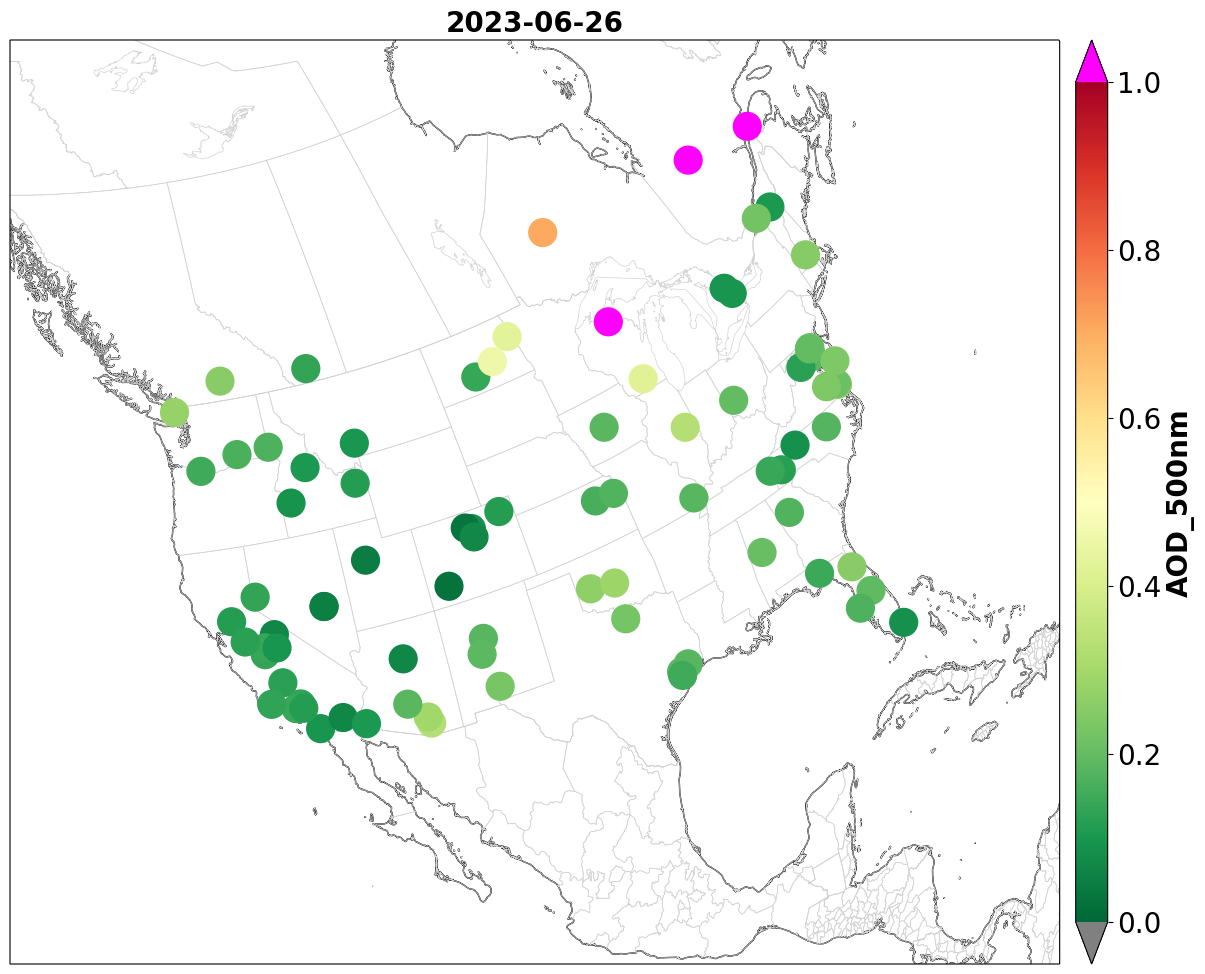

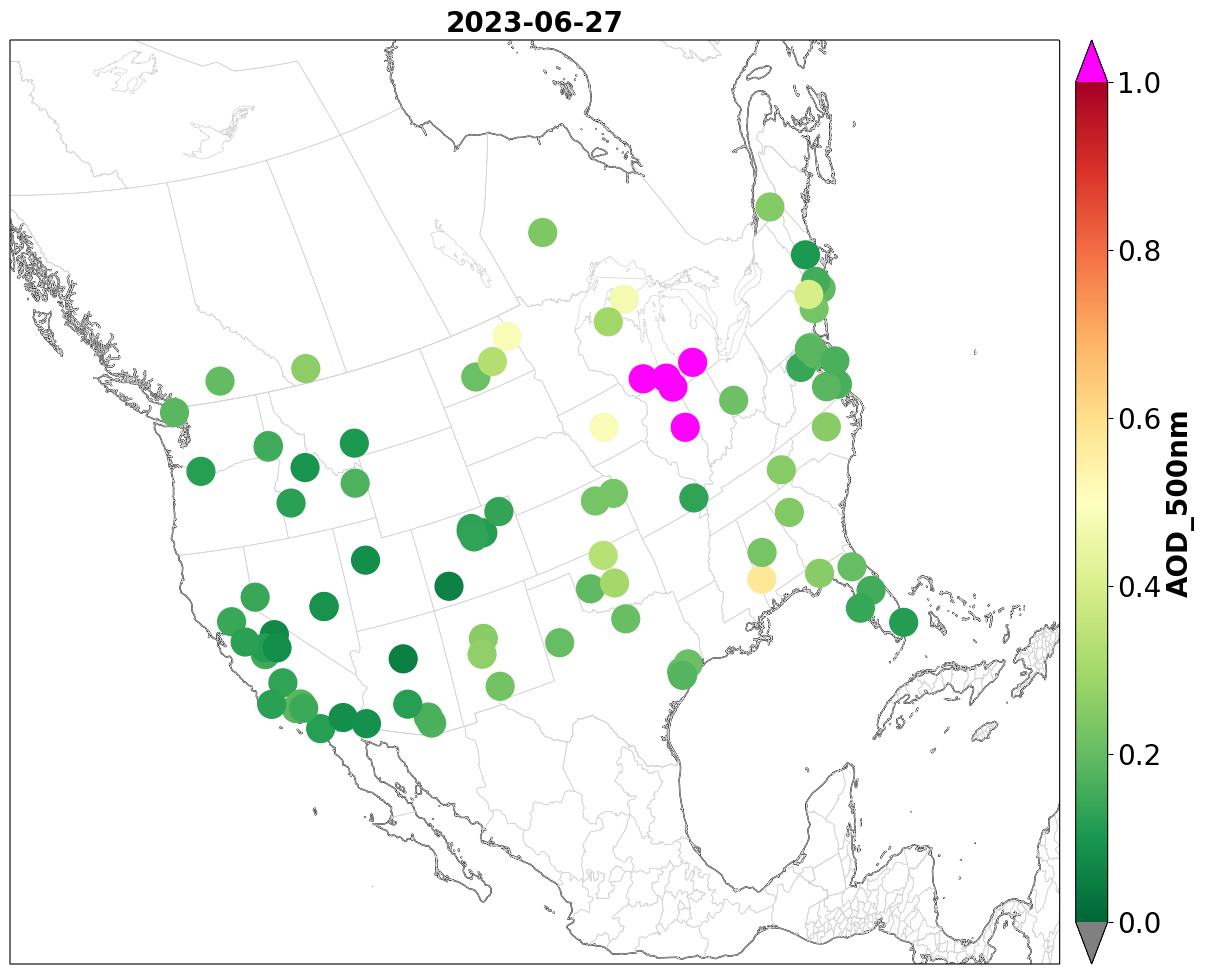

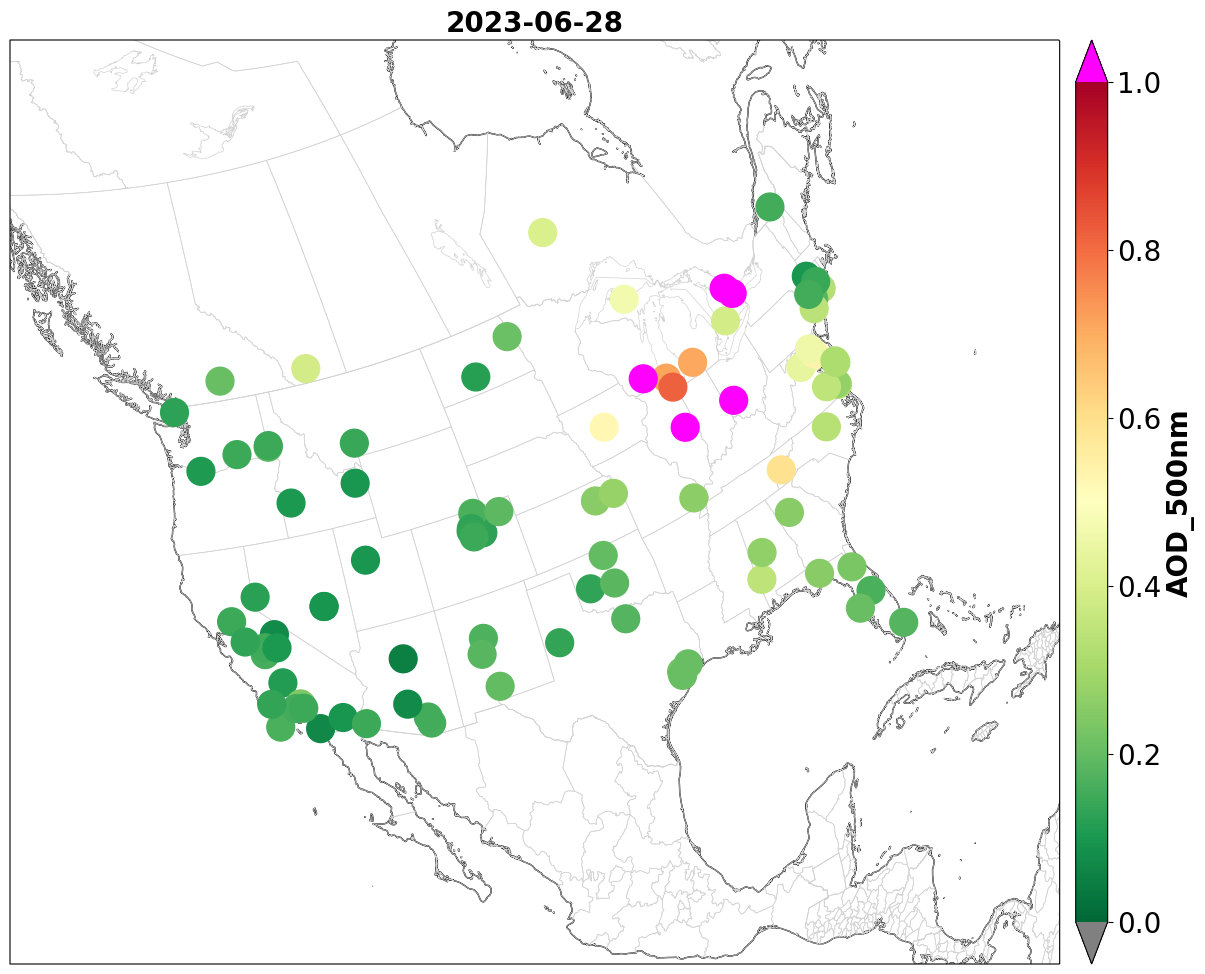

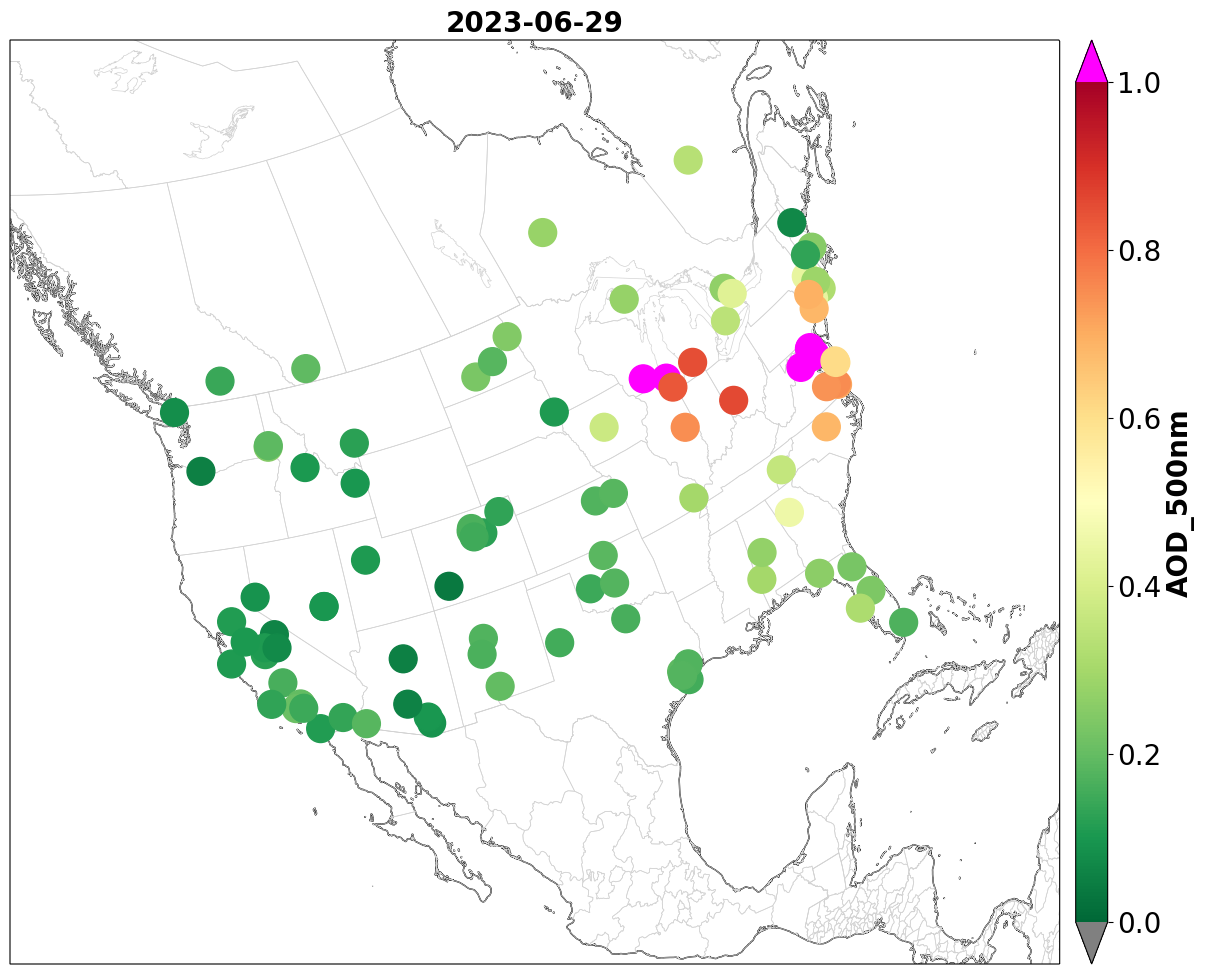

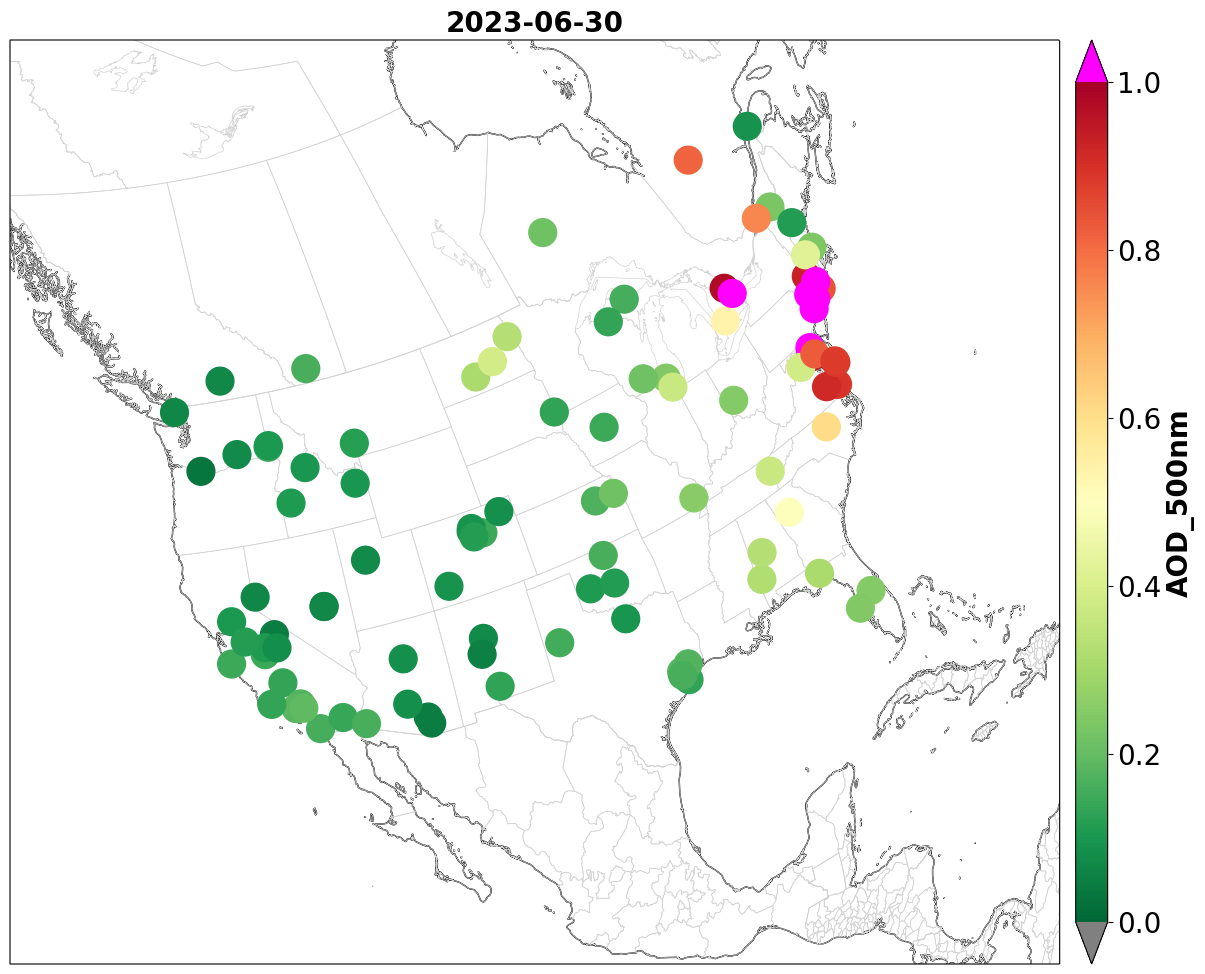

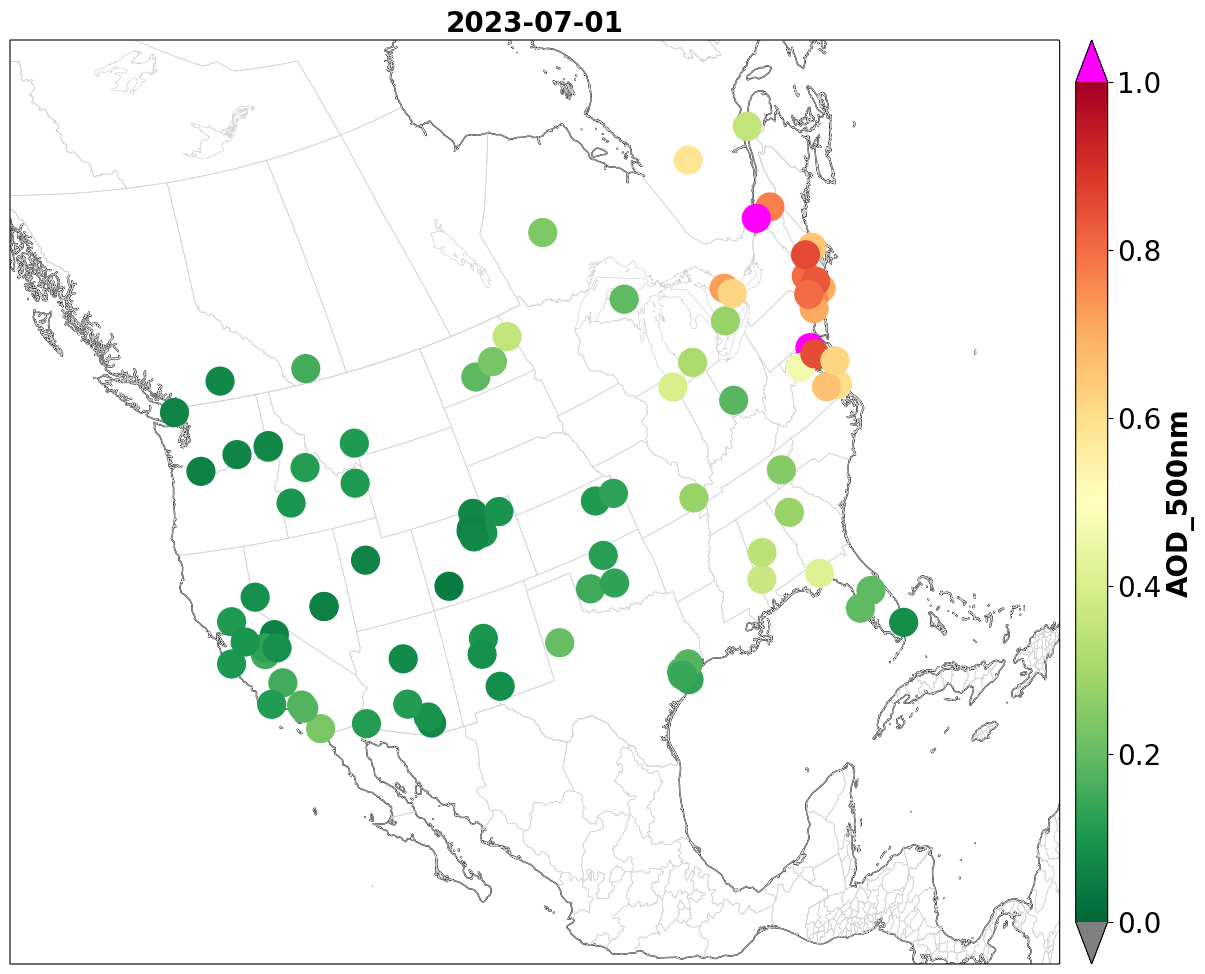

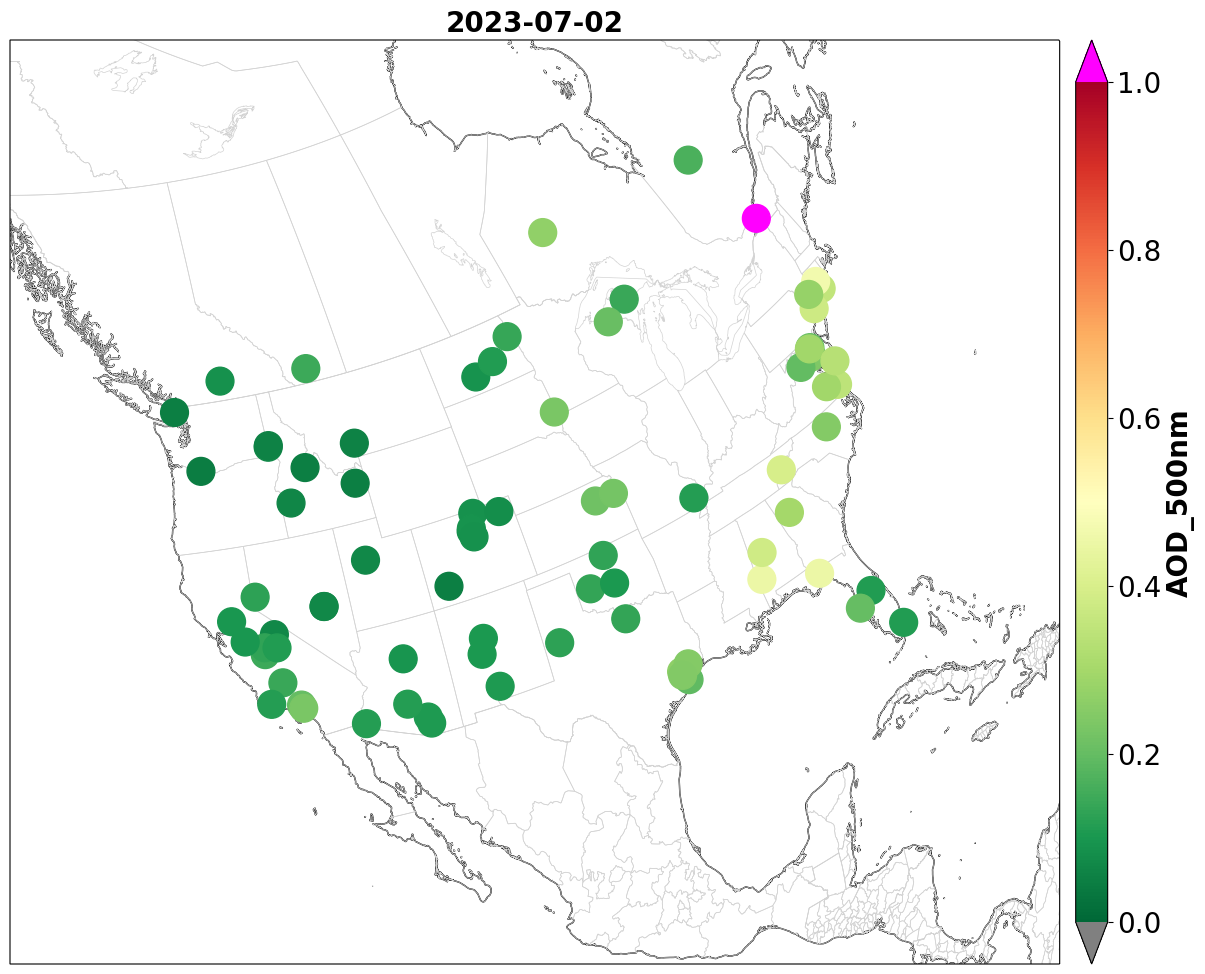

In [ ]:
## Define central location for Orthogrphic projection
central_longitude = long_west + abs (long_east- long_east)//2
central_latitude  = lat_south + abs (lat_south- lat_north)//2
#long_east =  central_longitude + 40
#long_west =  central_longitude  - 40
#lat_south =  central_latitude - 40
#lat_north =  central_latitude + 40

### ORTHO PROJECTION CELL
projection=ccrs.Orthographic(central_longitude=central_longitude, central_latitude=central_latitude)
geo = ccrs.Geodetic()

#points = projection.transform_points(geo, lons, lats)
outdir='/content/Output/'


colbar='RdYlGn_r' #https://matplotlib.org/stable/tutorials/colors/colormaps.html
#colbar='rainbow'

if average_type == 1:

  geo_df = dc(df)
  date_list = geo_df[['Date']].astype(str)
  date_list = date_list.to_numpy()
  date_list = np.unique(date_list)

  for i in range(len(date_list)):
    geo_df = dc(df)

    fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
    ax.set_extent([long_west,long_east,lat_south,lat_north],crs=ccrs.PlateCarree())
    #plt.xlim([long_west,long_east],tranfrom=geo)
    #plt.ylim([lat_south,lat_north])

    # Comment next 2 lines if you don't want grey color map
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    #countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

    geo_df = geo_df.loc[geo_df['Date'] == date_list[i]].reset_index(drop=True)
    colbar = plt.cm.get_cmap('RdYlGn_r')
    colbar.set_extremes(under='gray',over='magenta')
    cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                c=geo_df[geo_df.columns[-1]],
                cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=1,
                    #transform=geo
                    transform=ccrs.PlateCarree())
    ax.set_title(date_list[i],size=20, weight='bold')
    #ax.grid(alpha=0.1)
    # Add coastlines
    ax.coastlines(resolution='10m',zorder=0)

    # Add state and country boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

    #Add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar=plt.colorbar(cm, cax=cax, extend='both')
    cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
    tick_font_size = 20
    cbar.ax.tick_params(labelsize=tick_font_size)

    fig.savefig(outdir+'Output_'+str(date_list[i])+'_ortho.png')
    plt.show()

elif average_type == 2:
  geo_df = dc(df)
  geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
  geo_df['Hour'] = geo_df['Hour'].dt.time
  geo_df['Date_Time'] = geo_df.apply(lambda x : pd.datetime.combine(x['Date'],x['Hour']),1)
  geo_df.insert(3, 'Date_Time', geo_df.pop('Date_Time'))
  geo_df = geo_df.drop(columns=['Date', 'Hour'])

  date_list = geo_df[['Date_Time']].astype(str)
  date_list = date_list.to_numpy()
  date_list = np.unique(date_list)

  for i in range(len(date_list)):
    geo_df = dc(df)
    geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
    geo_df['Hour'] = geo_df['Hour'].dt.time
    geo_df['Date_Time'] = geo_df.apply(lambda x : pd.datetime.combine(x['Date'],x['Hour']),1)
    geo_df.insert(3, 'Date_Time', geo_df.pop('Date_Time'))
    geo_df = geo_df.drop(columns=['Date', 'Hour'])

    fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
    ax.set_extent([long_west,long_east,lat_south,lat_north],crs=ccrs.PlateCarree())
    #plt.xlim([long_west,long_east])
    #plt.ylim([lat_south,lat_north])

    # Comment next 2 lines if you don't want grey color map
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1,transform=ccrs.PlateCarree())


    geo_df = geo_df.loc[geo_df['Date_Time'] == date_list[i]].reset_index(drop=True)
    colbar = plt.cm.get_cmap('RdYlGn_r')
    colbar.set_extremes(under='gray',over='magenta')
    cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                    c=geo_df[geo_df.columns[-1]],
                cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=1,
                                        #transform=geo
                    transform=ccrs.PlateCarree())
    ax.set_title(date_list[i]+str(' GMT'),size=20, weight='bold')
    #ax.grid(alpha=0.1)

    # Add coastlines
    ax.coastlines(resolution='10m',zorder=0)

    # Add state and country boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

    #Add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar=plt.colorbar(cm, cax=cax, extend='both')
    cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
    tick_font_size = 20
    cbar.ax.tick_params(labelsize=tick_font_size)

    fig.savefig(outdir+'Output_'+str(date_list[i][:-6])+'_ortho.png')
    plt.show()

elif average_type == 3:
  geo_df = dc(df)
  fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
  ax.set_extent([long_west,long_east,lat_south,lat_north],crs=ccrs.PlateCarree())

  # Comment next 2 lines if you don't want grey color map
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
  countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

  # Add coastlines
  ax.coastlines(resolution='10m',zorder=1)

  # Add state and country boundaries
  ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)
  ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)

  #plt.xlim([long_west,long_east])
  #plt.ylim([lat_south,lat_north])
  colbar = plt.cm.get_cmap('RdYlGn_r')
  colbar.set_extremes(under='gray',over='magenta')
  cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                    c=geo_df[geo_df.columns[-1]],
                cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=2,transform=ccrs.PlateCarree())


  ax.set_title("Site Averages",size=20, weight='bold')
  #ax.grid(alpha=0.1)

  #Add colorbar
  cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
  plt.colorbar(cm, cax=cax, extend='both')
  cax.set_ylabel(geo_df.columns[-1])

  fig.savefig(outdir+'Output_Site_Average_ortho.png')
  plt.show()

**Download the saved maps as png file, it will zip all the files in the folder and download**

In [ ]:
while True:
  zip_download = str(input("Would you like to download your output in a zipped folder (y or n)?: "))
  if zip_download == 'y' or zip_download == 'Y' or zip_download == 'Yes' or zip_download == 'yes':
    shutil.make_archive('Output', 'zip', '/content/Output')  #zips all output files
    files.download('Output.zip')  #Note: Must use Chrome browser for download to work
    break
  elif zip_download == 'n' or zip_download == 'N' or zip_download == 'No' or zip_download == 'no':
    print("\nThanks! I hope you enjoyed the program.")
    break
  else:
    print("\nIncorrect input. Please try again!")

Would you like to download your output in a zipped folder (y or n)?: y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>